In [1]:
# Install required packages
import numpy as np
import matplotlib as plt

# Import pyomo environment and setup gurobi solver
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition
import gurobipy 
solver = pyo.SolverFactory("gurobi_direct")

from main_functions_XOR import *

In [2]:
# Set seed
np.random.seed(42)

In [3]:
# Create instances for Knapsack problem with logical features
KS_vals = [9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 6]
KS_wgts = [0.9, 0.02, 0.03, 0.01, 0.04, 0.005, 0.001, 0.015, 0.09, 0.0001]
KS_bdgt = 1
# Concatenate variables
inst = np.concatenate((KS_vals, KS_wgts, [KS_bdgt]))

all_prmt_dict = {}
features_lbls = []

for i in range(len(KS_vals)):
    all_prmt_dict['Value item ' + str(i+1)]  = KS_vals[i]
    # features_lbls.append('Value item ' + str(i+1))
for i in range(len(KS_wgts)):
    all_prmt_dict['Weight item ' + str(i+1)] = KS_wgts[i]
    features_lbls.append('Weight item ' + str(i+1))
all_prmt_dict['Maximum weight allowed'] = KS_bdgt

all_prmt_lbls = list(all_prmt_dict.keys())
all_prmt_vals = list(all_prmt_dict.values())

features_inds = [all_prmt_lbls.index(key) for key in features_lbls]
features_dict = {key: all_prmt_dict[key] for key in features_lbls}
features_vals = features_dict.values()

weight_widths = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10, 20]

pos_mdls_dict_prm = {'DecisionTreeRegressor':  {'max_depth': [2, 3, 4],
                                                'min_samples_leaf': [50, 100, 150]},
                    'LinearRegression':        {}
                    }

In [4]:
# Binary LP knapsack
def model_KS_bin(vals, output = 'goal', solver = solver):

    # Define a model
    model = pyo.ConcreteModel('Knapsack 0-1 model')

    # Declare decision variables
    model.x = pyo.Var(range(int(((len(vals)-1)/2))), domain=pyo.Binary)

    # Declare objective
    model.objective = pyo.Objective(expr = sum(vals[i]*model.x[i] for i in range(int(((len(vals)-1)/2)))),
                                sense = pyo.maximize)

    # Declare constraints
    model.budget = pyo.Constraint(expr = sum(vals[i+int(((len(vals)-1)/2))]*model.x[i] for i in range(int(((len(vals)-1)/2)))) <= vals[-1])

    # Solve
    result = solver.solve(model)

    if output == 'goal':
        return model.objective()

    elif output == 'bounded' or output == 'feasibility':
        return result.solver.termination_condition != TerminationCondition.infeasibleOrUnbounded
    
    elif output == 'decision vector':
        solutions = []
        for i in range(int(((len(vals)-1)/2))):
            solutions.append(pyo.value(model.x[i]))
        return solutions
    
    else:
        raise ValueError("Output not supported for model function")

In [5]:
# Continuous LP knapsack
def model_KS_cts(vals, output = 'goal', solver = solver):

    # Define a model
    model = pyo.ConcreteModel('Knapsack continuous model')

    # Declare decision variables
    model.x = pyo.Var(range(int(((len(vals)-1)/2))), domain=pyo.NonNegativeReals, bounds=(0, 1))

    # Declare objective
    model.objective = pyo.Objective(expr = sum(vals[i]*model.x[i] for i in range(int(((len(vals)-1)/2)))),
                                sense = pyo.maximize)

    # Declare constraints
    model.budget = pyo.Constraint(expr = sum(vals[i+int(((len(vals)-1)/2))]*model.x[i] for i in range(int(((len(vals)-1)/2)))) <= vals[-1])

    # Solve
    result = solver.solve(model)

    if output == 'goal':
        return model.objective()

    elif output == 'bounded' or output == 'feasibility':
        return result.solver.termination_condition != TerminationCondition.infeasibleOrUnbounded
    
    else:
        raise ValueError("Output not supported for model function")

In [6]:
# Heuristic for Knapsack
def model_KS_hrs(vals, output = 'goal'):
    if output == 'goal':
        # Sort ratios
        arr = []
        for i in range(int(((len(vals)-1)/2))):
            arr.append([vals[i], vals[i+int(((len(vals)-1)/2))], i])

        arr.sort(key=lambda x: (x[0]/x[1]), reverse=True)
        finalvalue = 0.0 # Result(value in Knapsack)
        W = vals[-1]

        # Looping through all Items
        for item in arr:
        # If adding Item won't overflow, add it completely
            if item[1] <= W:
                W -= item[1]
                finalvalue += item[0]
            else:
                break
        return finalvalue

    elif output == 'bounded' or output == 'feasibility':
        return True #Cannot occur
    
    else:
        raise ValueError("Output not supported for model function")

In [7]:
# Print outcome of the three models applied to instance
print(model_KS_bin(inst))
print(model_KS_cts(inst))
print(model_KS_hrs(inst))

18.0
18.288999999999998
9.5


# Explaining optimal value

## Parametric optimization + approximation

In [8]:
# Create a perturbation vecotr
KS_prtb = np.concatenate((np.zeros(10), [0.2, 0.01, 0.058, 0.02, 0.075, 0.009, 0.002, 0.028, 0.15, 0.0002], [0]))


# Sample 1000 instances, determine target values, and determine proximity to original problem -> weights
# Then, train and test candidate surrogate models
lmb_samples = np.concatenate(([0], np.random.uniform(-0.5,6,1000)))
val_samples = []
outcome_dict_prm_approx_bin = {}
outcome_dict_prm_approx_hrs = {}
outcome_dict_prm_approx_dif = {}

for lmb in lmb_samples:
    val_samples.append(inst+ lmb*KS_prtb)

yvalues_bin = get_values_from_samples(val_samples, model_KS_bin)
yvalues_hrs = get_values_from_samples(val_samples, model_KS_hrs)
yvalues_dif = list(map(lambda a, b: a - b, yvalues_bin, yvalues_hrs))

for wdth in weight_widths:
    weights_lcl = get_weights_from_samples(lmb_samples, ftr_index_list=[0], width=wdth)
    if np.sum(weights_lcl) > 0:
        outcome_dict_prm_approx_bin['Width: '+str(wdth)] = train_test_explanation_models(pos_mdls_dict_prm, lmb_samples, yvalues_bin, weights_lcl, feature_indices=[0], store_all=False)
        outcome_dict_prm_approx_hrs['Width: '+str(wdth)] = train_test_explanation_models(pos_mdls_dict_prm, lmb_samples, yvalues_hrs, weights_lcl, feature_indices=[0], store_all=False)    
        outcome_dict_prm_approx_dif['Width: '+str(wdth)] = train_test_explanation_models(pos_mdls_dict_prm, lmb_samples, yvalues_dif, weights_lcl, feature_indices=[0], store_all=False)

c:\Users\DOTTO1\AppData\Local\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:587: RuntimeWarning: invalid value encountered in divide
  return self.tree_.compute_feature_importances()


In [9]:
# Apply origanal optimization model and found surrogates to full parameterspace such that we can plot the outcome
lambda_plot = np.linspace(start = -.5, stop = 6.0, num=1000).reshape(-1, 1)

y_plot_bin = []
y_plot_hrs = []
y_plot_dif = []
y_plot_DTR_bin = {}
y_plot_LR_bin  = {}
y_plot_DTR_hrs = {}
y_plot_LR_hrs  = {}
y_plot_DTR_dif = {}
y_plot_LR_dif  = {}


for lmb in lambda_plot:
    y_bin = model_KS_bin(inst+ lmb*KS_prtb)
    y_hrs = model_KS_hrs(inst+ lmb*KS_prtb)
    y_plot_bin.append(y_bin)
    y_plot_hrs.append(y_hrs)
    y_plot_dif.append(y_bin-y_hrs)

for wdth in weight_widths:
    lcl_dict = outcome_dict_prm_approx_bin['Width: '+str(wdth)]
    if len(lcl_dict.keys()) > 0:
        DTR_model = lcl_dict['DecisionTreeRegressor']['Model']
        y_plot_DTR_bin['Width: '+str(wdth)] = DTR_model.predict(lambda_plot)

        LR_model  = lcl_dict['LinearRegression']['Model']
        y_plot_LR_bin['Width: '+str(wdth)] = LR_model.predict(lambda_plot)

    lcl_dict = outcome_dict_prm_approx_hrs['Width: '+str(wdth)]
    if len(lcl_dict.keys()) > 0:
        DTR_model = lcl_dict['DecisionTreeRegressor']['Model']
        y_plot_DTR_hrs['Width: '+str(wdth)] = DTR_model.predict(lambda_plot)

        LR_model  = lcl_dict['LinearRegression']['Model']
        y_plot_LR_hrs['Width: '+str(wdth)] = LR_model.predict(lambda_plot)
        
    lcl_dict = outcome_dict_prm_approx_dif['Width: '+str(wdth)]
    if len(lcl_dict.keys()) > 0:
        DTR_model = lcl_dict['DecisionTreeRegressor']['Model']
        y_plot_DTR_dif['Width: '+str(wdth)] = DTR_model.predict(lambda_plot)

        LR_model  = lcl_dict['LinearRegression']['Model']
        y_plot_LR_dif['Width: '+str(wdth)] = LR_model.predict(lambda_plot)

C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_22716\1174757540.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  arr.sort(key=lambda x: (x[0]/x[1]), reverse=True)


In [10]:
#Subset of proximity parameters which we want to plot
subweights = [0.01, 0.1, 0.5, 1, 2, 5, 10]

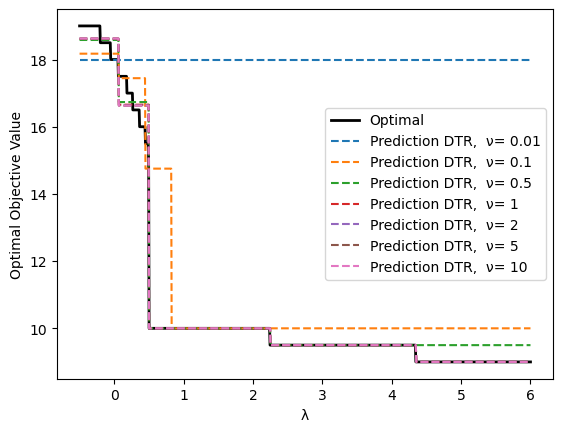

In [11]:
# Plot value found by optimization model, DTR predictions for different proximity parameters
fig = plt.figure()
plt.plot(lambda_plot, y_plot_bin, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
for wdth in subweights:
    if 'Width: '+str(wdth) in y_plot_DTR_bin.keys():
        plt.plot(lambda_plot, y_plot_DTR_bin['Width: '+str(wdth)], label = 'Prediction DTR,  \u03BD= ' + str(wdth), linestyle = '--', linewidth =1.5) 

plt.legend() 
plt.xlabel("\u03BB")
plt.ylabel("Optimal Objective Value") 
plt.show()

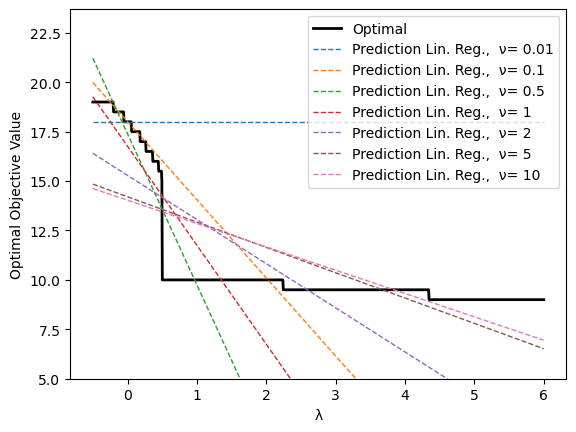

In [12]:
# Plot value found by optimization model, Lin Reg predictions for different proximity parameters
fig = plt.figure()
plt.plot(lambda_plot, y_plot_bin, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
for wdth in subweights:
    if 'Width: '+str(wdth) in y_plot_LR_bin.keys():
        plt.plot(lambda_plot, y_plot_LR_bin['Width: '+str(wdth)], label = 'Prediction Lin. Reg.,  \u03BD= ' + str(wdth), linestyle = '--', linewidth =1) 

plt.legend() 
plt.xlabel("\u03BB")
plt.ylabel("Optimal Objective Value") 
plt.ylim(5)
plt.show()

C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_22716\604610251.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.xticks(np.arange(min(lambda_plot), max(lambda_plot)+.5, .5))


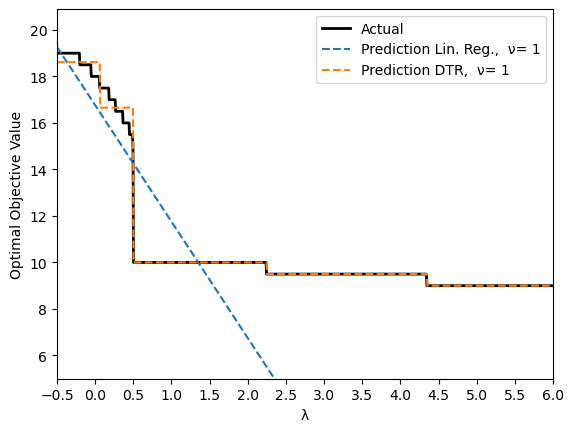

In [13]:
# Plot value found by optimization model, DTR predictions, Linear Regression predictions for one proximity parameter
plt.plot(lambda_plot, y_plot_bin, color = 'black', linestyle = '-', label = "Actual", linewidth =2) 
plt.plot(lambda_plot, y_plot_LR_bin['Width: '+str(1)], label = 'Prediction Lin. Reg.,  \u03BD= ' + str(1), linestyle = '--', linewidth =1.5) 
plt.plot(lambda_plot, y_plot_DTR_bin['Width: '+str(1)], label = 'Prediction DTR,  \u03BD= ' + str(1), linestyle = '--', linewidth =1.5) 
plt.legend() 
plt.xlabel("\u03BB")
plt.ylabel("Optimal Objective Value") 
plt.ylim(5)
plt.xlim(-.5,6)
plt.xticks(np.arange(min(lambda_plot), max(lambda_plot)+.5, .5))
plt.show()

C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_22716\3953180551.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.xticks(np.arange(min(lambda_plot), max(lambda_plot)+.5, .5))


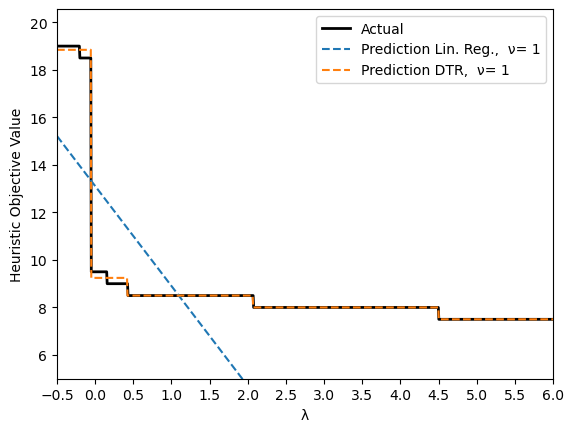

In [14]:
# Plot value found by herusitic, DTR predictions, Linear Regression predictions for one proximity parameter
plt.plot(lambda_plot, y_plot_hrs, color = 'black', linestyle = '-', label = "Actual", linewidth =2) 
plt.plot(lambda_plot, y_plot_LR_hrs['Width: '+str(1)], label = 'Prediction Lin. Reg.,  \u03BD= ' + str(1), linestyle = '--', linewidth =1.5) 
plt.plot(lambda_plot, y_plot_DTR_hrs['Width: '+str(1)], label = 'Prediction DTR,  \u03BD= ' + str(1), linestyle = '--', linewidth =1.5) 
plt.legend() 
plt.xlabel("\u03BB")
plt.ylabel("Heuristic Objective Value") 
plt.ylim(5)
plt.xlim(-.5,6)
plt.xticks(np.arange(min(lambda_plot), max(lambda_plot)+.5, .5))
plt.show()

C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_22716\3805876270.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.xticks(np.arange(min(lambda_plot), max(lambda_plot)+.5, .5))


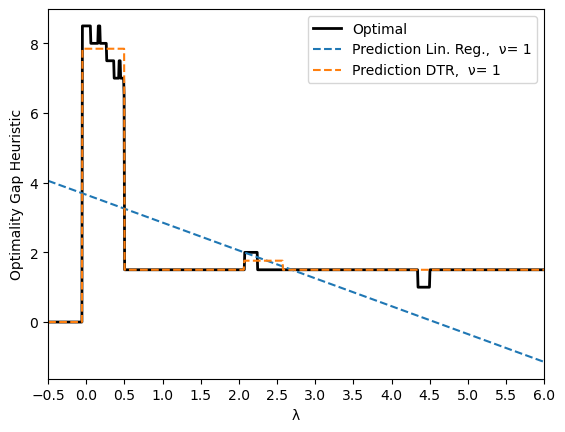

In [15]:
# Plot optimzality gap of heuristic, DTR predictions, Linear Regression predictions for one proximity parameter
plt.plot(lambda_plot, y_plot_dif, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
plt.plot(lambda_plot, y_plot_LR_dif['Width: '+str(1)], label = 'Prediction Lin. Reg.,  \u03BD= ' + str(1), linestyle = '--', linewidth =1.5) 
plt.plot(lambda_plot, y_plot_DTR_dif['Width: '+str(1)], label = 'Prediction DTR,  \u03BD= ' + str(1), linestyle = '--', linewidth =1.5) 
plt.legend() 
plt.xlabel("\u03BB")
plt.ylabel("Optimality Gap Heuristic") 
plt.ylim()
plt.xlim(-.5,6)
plt.xticks(np.arange(min(lambda_plot), max(lambda_plot)+.5, .5))
plt.show()

## All paramaters

In [16]:
# Create instances for Knapsack problem with logical features
KS_vals = [9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 6]
KS_wgts = [0.9, 0.02, 0.03, 0.01, 0.04, 0.005, 0.001, 0.015, 0.09, 0.0001]
KS_bdgt = 1
# Concatenate variables
inst = np.concatenate((KS_vals, KS_wgts, [KS_bdgt]))

all_prmt_dict = {}
features_lbls = []
features_lbls_nl = []

for i in range(len(KS_vals)):
    all_prmt_dict['Value item ' + str(i+1)]  = KS_vals[i]
    features_lbls.append('Value item ' + str(i+1))
    features_lbls_nl.append('Value \n item ' + str(i+1))
for i in range(len(KS_wgts)):
    all_prmt_dict['Weight item ' + str(i+1)] = KS_wgts[i]
    features_lbls.append('Weight item ' + str(i+1))
    features_lbls_nl.append('Weight \n item ' + str(i+1))
all_prmt_dict['Maximum weight allowed'] = KS_bdgt

all_prmt_lbls = list(all_prmt_dict.keys())
all_prmt_vals = list(all_prmt_dict.values())

features_inds = [all_prmt_lbls.index(key) for key in features_lbls]
features_dict = {key: all_prmt_dict[key] for key in features_lbls}
features_vals = features_dict.values()

weight_widths = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10]


pos_mdls_dict_all = {'DecisionTreeRegressor':  {'max_depth': [3, 4, 5],
                                                'min_samples_leaf': [50, 100, 150]},
                    'LinearRegression':        {},
                    'RidgeRegression':         {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]},
                    'LASSORegression':         {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]}
                    }

In [17]:
# Get samples, weights, and values
samples = sample_perturbations_normal(all_prmt_vals, features_inds, var=0.1, model_lcl = model_KS_bin)
weights = []
for wdth in weight_widths:
    weights.append(get_weights_from_samples(samples, features_inds, width=wdth))
yvalues_ilp = get_values_from_samples(samples, model_KS_bin)
yvalues_hrs = get_values_from_samples(samples, model_KS_hrs)

outcome_dict_all_prm_ilp = train_test_explanation_models(pos_mdls_dict_all, samples, yvalues_ilp, weights[4], features_inds, store_all=False)
outcome_dict_all_prm_hrs = train_test_explanation_models(pos_mdls_dict_all, samples, yvalues_hrs, weights[4], features_inds, store_all=False)

In [18]:
# Print model WSME for predicting optimal value found by 1. ILP and 2. Heuristic
for model_type in list(pos_mdls_dict_all.keys()):
    Wmse_ilp = outcome_dict_all_prm_ilp[model_type]['Wmse']
    Wmse_hrs = outcome_dict_all_prm_hrs[model_type]['Wmse']
    print(model_type, 'ILP Wmse: '+str(Wmse_ilp), 'Heuristic Wmse: '+str(Wmse_hrs))

DecisionTreeRegressor ILP Wmse: 0.2495219123682301 Heuristic Wmse: 3.6006713826905776
LinearRegression ILP Wmse: 3.31758128932572 Heuristic Wmse: 7.093125504486741
RidgeRegression ILP Wmse: 3.25414543305093 Heuristic Wmse: 7.0042976979434455
LASSORegression ILP Wmse: 3.1784773179193055 Heuristic Wmse: 6.937724884569419


<Figure size 640x480 with 0 Axes>

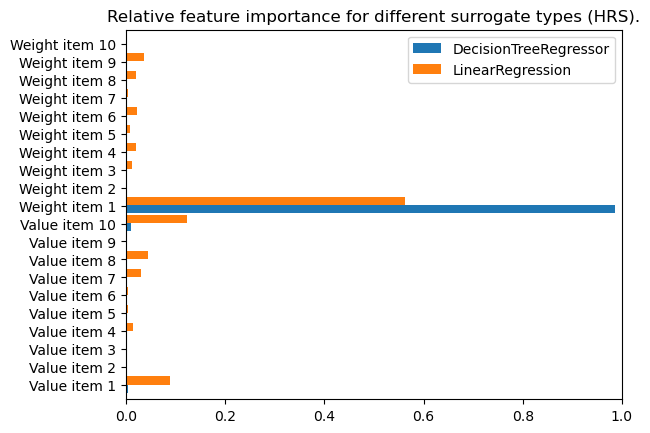

In [54]:
# Print model WSME for predicting optimal value found by 1. ILP and 2. Heuristic
surrogate_plots = ['DecisionTreeRegressor', 'LinearRegression']

ind = np.arange(len(features_lbls))
width = 1/(len(surrogate_plots)+0.2)

fig = plt.figure()
fig, ax = plt.subplots()
for i in range(len(surrogate_plots)):
    ftr_imp = outcome_dict_all_prm_hrs[surrogate_plots[i]]['Best model feature importance']
    ax.barh(ind +i* width, ftr_imp, width, label=surrogate_plots[i])

ax.set(yticks=ind + 0.2, yticklabels=features_lbls, ylim=[2*width -1.5, len(features_lbls)])
plt.title('Relative feature importance for different surrogate types (HRS).')
plt.xlim(0,1)
plt.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

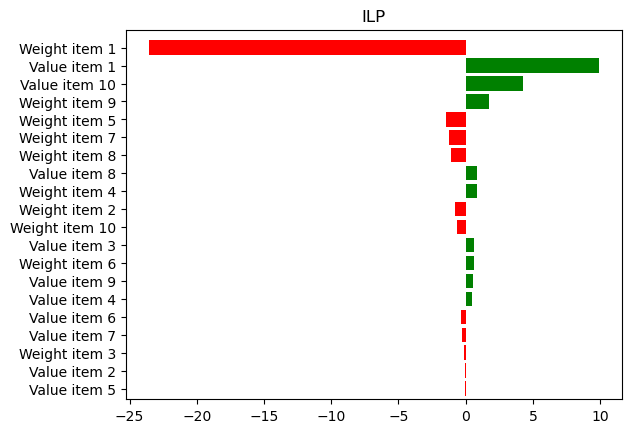

<Figure size 640x480 with 0 Axes>

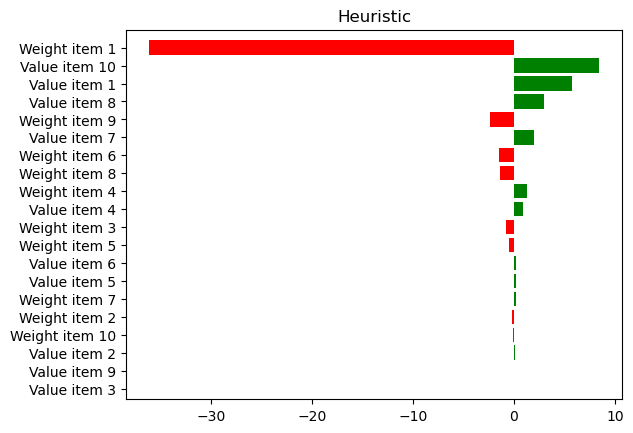

In [21]:
#print tornado plot, feature contribution, for linear regression surrogate
surrogate_plots = ['LinearRegression']

ind = np.arange(len(features_lbls))

for i in surrogate_plots:
    fig = plt.figure()
    fig, ax = plt.subplots()
    trndo = np.multiply(outcome_dict_all_prm_ilp[i]['Best model coefficients'], [all_prmt_vals[i] for i in features_inds])
    trndo_srt = sorted(trndo, key=abs)
    profit_color = [('green' if t > 0 else 'red') for t in trndo_srt]
    idx = np.argsort(np.abs(trndo))
    features_lbls_srt = (np.array(features_lbls)[idx])
    ax.barh(features_inds, trndo_srt, color = profit_color)
    ax.set(yticks=ind, yticklabels=features_lbls_srt, ylim=[2*width - 1, len(features_lbls)])
    plt.title('ILP')
    plt.show()
for i in surrogate_plots:
    fig = plt.figure()
    fig, ax = plt.subplots()
    trndo = np.multiply(outcome_dict_all_prm_hrs[i]['Best model coefficients'], [all_prmt_vals[i] for i in features_inds])
    trndo_srt = sorted(trndo, key=abs)
    profit_color = [('green' if t > 0 else 'red') for t in trndo_srt]
    idx = np.argsort(np.abs(trndo))
    features_lbls_srt = (np.array(features_lbls)[idx])
    ax.barh(features_inds, trndo_srt, color = profit_color)
    ax.set(yticks=ind, yticklabels=features_lbls_srt, ylim=[2*width - 1, len(features_lbls)])
    plt.title('Heuristic')
    plt.show()


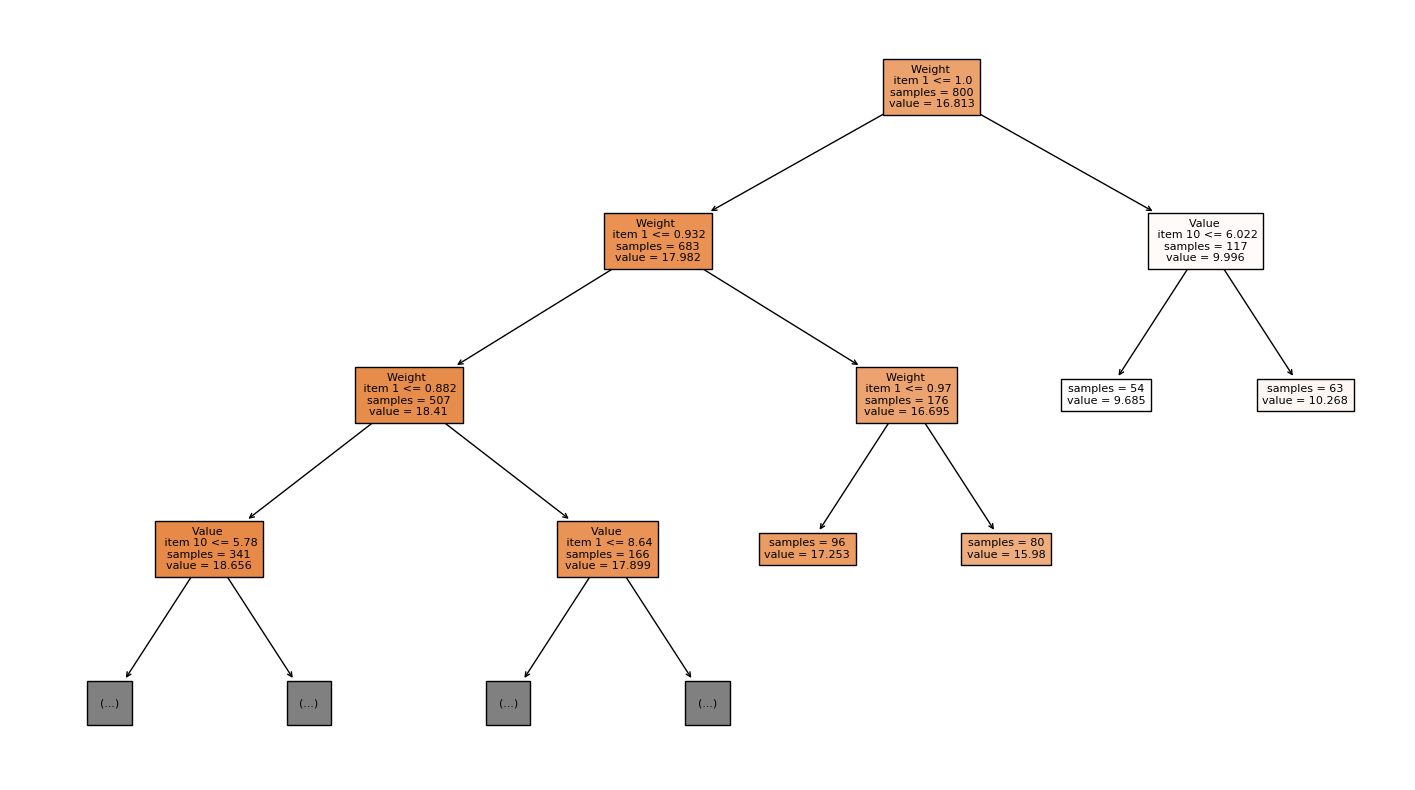

In [43]:
#Plot tree for DTR surrogate for ILP objective value
plt.figure(figsize=(18,10))
plot_tree(outcome_dict_all_prm_ilp['DecisionTreeRegressor']['Model'], feature_names = features_lbls_nl, fontsize=8, impurity=False, filled=True, max_depth=3)
plt.show()

#Plot tree for DTR surrogate for heuristic objective value
plt.figure(figsize=(18,10))
plot_tree(outcome_dict_all_prm_hrs['DecisionTreeRegressor']['Model'], feature_names = features_lbls_nl, fontsize=8, impurity=False, filled=True, max_depth=3)
plt.show()

## Only weight (constraint) parameters

In [23]:
# Set weight feature indices
features_w = features_inds[10:20]

# Get samples, weights, and values
samples_w = sample_perturbations_normal(all_prmt_vals, features_w, var=0.2, model_lcl = model_KS_bin)
weights_w = []
for wdth in weight_widths:
    weights_w.append(get_weights_from_samples(samples_w, features_w, width=wdth))
yvalues_ilp_w = get_values_from_samples(samples_w, model_KS_bin)
yvalues_hrs_w = get_values_from_samples(samples_w, model_KS_hrs)

outcome_dict_w_prm_ilp = train_test_explanation_models(pos_mdls_dict_all, samples_w, yvalues_ilp_w, weights_w[4], features_w, store_all=False)
outcome_dict_w_prm_hrs = train_test_explanation_models(pos_mdls_dict_all, samples_w, yvalues_hrs_w, weights_w[4], features_w, store_all=False)

In [24]:
# Print WMSE for different surrogate models predicting objective value found by 1. ILP solver and 2. heuristic
for model_type in list(pos_mdls_dict_all.keys()):
    Wmse_ilp = outcome_dict_w_prm_ilp[model_type]['Wmse']
    Wmse_hrs = outcome_dict_w_prm_hrs[model_type]['Wmse']
    print(model_type, 'ILP Wmse: '+str(Wmse_ilp), 'Heuristic Wmse: '+str(Wmse_hrs))

DecisionTreeRegressor ILP Wmse: 0.1740075480459012 Heuristic Wmse: 1.5011185051369804
LinearRegression ILP Wmse: 4.718689341886043 Heuristic Wmse: 7.603223685154796
RidgeRegression ILP Wmse: 4.625751776568551 Heuristic Wmse: 7.577783677835437
LASSORegression ILP Wmse: 4.5265308839499605 Heuristic Wmse: 7.58099938762085


<Figure size 640x480 with 0 Axes>

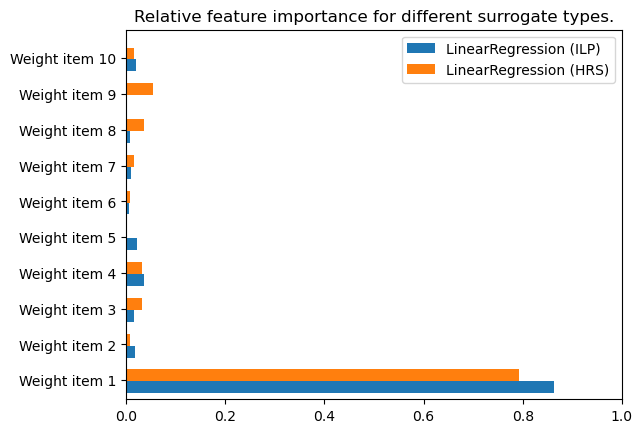

In [25]:
# Plot relative feature importance of Lin Reg surrogate models
surrogate_plots = ['LinearRegression']

ind = np.arange(len(features_lbls[10:20]))
width = 1/(2*len(surrogate_plots)+1)

fig = plt.figure()
fig, ax = plt.subplots()
for i in range(len(surrogate_plots)):
    ftr_imp_ilp = outcome_dict_w_prm_ilp[surrogate_plots[i]]['Best model feature importance']
    ax.barh(ind +i* width, ftr_imp_ilp, width, label=surrogate_plots[i]+' (ILP)')
    ftr_imp_hrs = outcome_dict_w_prm_hrs[surrogate_plots[i]]['Best model feature importance']
    ax.barh(ind +(i+1)* width, ftr_imp_hrs, width, label=surrogate_plots[i]+' (HRS)')

ax.set(yticks=ind+0.2 , yticklabels=features_lbls[10:20], ylim=[2*width - 1, len(features_lbls[10:20])])
plt.title('Relative feature importance for different surrogate types.')
plt.xlim(0,1)
plt.legend()
plt.show()

## Only value (=cost) parameters

In [26]:
# Set right indices for features
features_v = features_inds[:10]

# Get samples, weights, and values
samples_v = sample_perturbations_normal(all_prmt_vals, features_v, var=0.2, model_lcl = model_KS_bin)
weights_v = []
for wdth in weight_widths:
    weights_v.append(get_weights_from_samples(samples_v, features_v, width=wdth))
yvalues_ilp_v = get_values_from_samples(samples_v, model_KS_bin)
yvalues_hrs_v = get_values_from_samples(samples_v, model_KS_hrs)

outcome_dict_v_prm_ilp = train_test_explanation_models(pos_mdls_dict_all, samples_v, yvalues_ilp_v, weights_v[4], features_v, store_all=False)
outcome_dict_v_prm_hrs = train_test_explanation_models(pos_mdls_dict_all, samples_v, yvalues_hrs_v, weights_v[4], features_v, store_all=False)

In [27]:
# Print WMSE for different surrogate models predicting objective value found by 1. ILP solver and 2. heuristic
for model_type in list(pos_mdls_dict_all.keys()):
    Wmse_ilp = outcome_dict_v_prm_ilp[model_type]['Wmse']
    Wmse_hrs = outcome_dict_v_prm_hrs[model_type]['Wmse']
    print(model_type, 'ILP Wmse: '+str(Wmse_ilp), 'Heuristic Wmse: '+str(Wmse_hrs))

DecisionTreeRegressor ILP Wmse: 0.2091025493559206 Heuristic Wmse: 1.9709387053637915
LinearRegression ILP Wmse: 0.0017340652302259378 Heuristic Wmse: 5.980127056925549
RidgeRegression ILP Wmse: 0.0017379686397961892 Heuristic Wmse: 5.982588364840456
LASSORegression ILP Wmse: 0.0030010076238111264 Heuristic Wmse: 5.989603335609153


<Figure size 640x480 with 0 Axes>

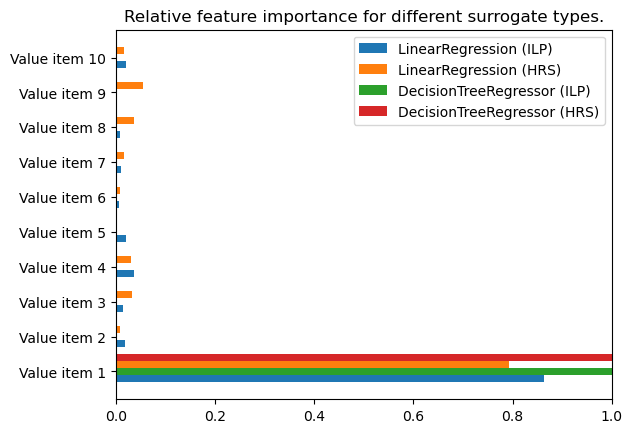

In [28]:
# Plot relative feature importance of Lin Reg and DTR surrogate models
surrogate_plots = ['LinearRegression', 'DecisionTreeRegressor']

ind = np.arange(len(features_lbls[10:20]))
width = 1/(2*len(surrogate_plots)+1)

fig = plt.figure()
fig, ax = plt.subplots()
for i in range(len(surrogate_plots)):
    ftr_imp_ilp = outcome_dict_w_prm_ilp[surrogate_plots[i]]['Best model feature importance']
    ax.barh(ind +i* width, ftr_imp_ilp, width, label=surrogate_plots[i]+' (ILP)')
    ftr_imp_hrs = outcome_dict_w_prm_hrs[surrogate_plots[i]]['Best model feature importance']
    ax.barh(ind +(i+2)* width, ftr_imp_hrs, width, label=surrogate_plots[i]+' (HRS)')

ax.set(yticks=ind+0.2 , yticklabels=features_lbls[:10], ylim=[2*width - 1, len(features_lbls[10:20])])
plt.title('Relative feature importance for different surrogate types.')
plt.xlim(0,1)
plt.legend()
plt.show()

# Explaining feasibility of original solution

## Only using constraint/weight parameters 
(costs parameters do not influence this)

In [29]:
# Find original optimal decision vector
orig_dcsn_vctr = model_KS_bin(inst, output = 'decision vector')

# Define function for checking feasibility of a decision vector given weight parameter values 
def check_feasibility_KS(values, orig_dcsn = orig_dcsn_vctr):
    if np.dot(orig_dcsn, values[10:20]) <= values[-1]:
        return 1
    else:
        return 0

In [30]:
# Set potential surrogate model
pos_mdls_dict_fsb = {'DecisionTreeClassifier':  {'max_depth': [2, 3, 4],
                                                'min_samples_leaf': [50, 100, 150]},
                    'LogisticRegression':       {}
                    }

features_w = features_inds[10:20]

# Get samples, weights, and values
weights_w = []
for wdth in weight_widths:
    weights_w.append(get_weights_from_samples(samples_w, features_w, width=wdth))
yvalues_fsb_w = get_values_from_samples(samples_w, check_feasibility_KS)

#Predict
outcome_dict_w_fsb = train_test_explanation_models(pos_mdls_dict_fsb, samples_w, yvalues_fsb_w, weights_w[3], features_w, store_all=False)

In [31]:
# Print WMSE of different surrogate candidates
for model_type in list(pos_mdls_dict_fsb.keys()):
    Wmse = outcome_dict_w_fsb[model_type]['Wmse']
    print(model_type, 'Wmse: '+str(Wmse))

DecisionTreeClassifier Wmse: 0.03070440895150843
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
LogisticRegression Wmse: 0.22055387631257514
[9.97169524e-01 5.73817679e-05 1.44879703e-04 2.86053116e-05
 2.19924449e-04 5.93891194e-07 5.30458582e-08 1.05793396e-05
 2.36845841e-03 7.90302726e-11]


<Figure size 640x480 with 0 Axes>

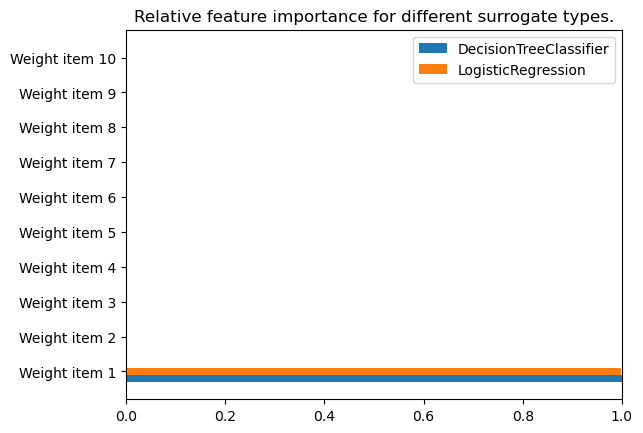

In [33]:
# Plot relative feature importance of DTR and LR
surrogate_plots = list(pos_mdls_dict_fsb.keys())

ind = np.arange(len(features_lbls[10:20]))
width = 1/(2*len(surrogate_plots)+1)

fig = plt.figure()
fig, ax = plt.subplots()
for i in range(len(surrogate_plots)):
    ftr_imp = outcome_dict_w_fsb[surrogate_plots[i]]['Best model feature importance']
    ax.barh(ind +i* width, ftr_imp, width, label=surrogate_plots[i])

ax.set(yticks=ind+0.2 , yticklabels=features_lbls[10:20], ylim=[2*width - 1, len(features_lbls[10:20])])
plt.title('Relative feature importance for different surrogate types.')
plt.xlim(0,1)
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

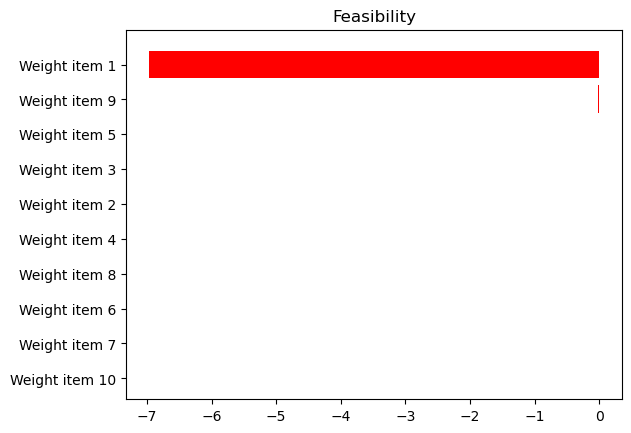

In [34]:
#print tornado plot, feature contribution, for linear regression surrogate
ind = np.arange(len(features_w))

for i in ['LogisticRegression']:
    fig = plt.figure()
    fig, ax = plt.subplots()
    trndo = np.multiply(outcome_dict_w_fsb[i]['Best model coefficients'], [all_prmt_vals[i] for i in features_w])
    trndo_srt = sorted(trndo, key=abs)
    profit_color = [('green' if t > 0 else 'red') for t in trndo_srt]
    idx = np.argsort(np.abs(trndo))
    features_lbls_srt = (np.array(features_lbls[10:20])[idx])
    ax.barh([*range(10)], trndo_srt, color = profit_color)
    ax.set(yticks=ind, yticklabels=features_lbls_srt, ylim=[2*width - 1, len(features_w)])
    plt.title('Feasibility')
    plt.show()

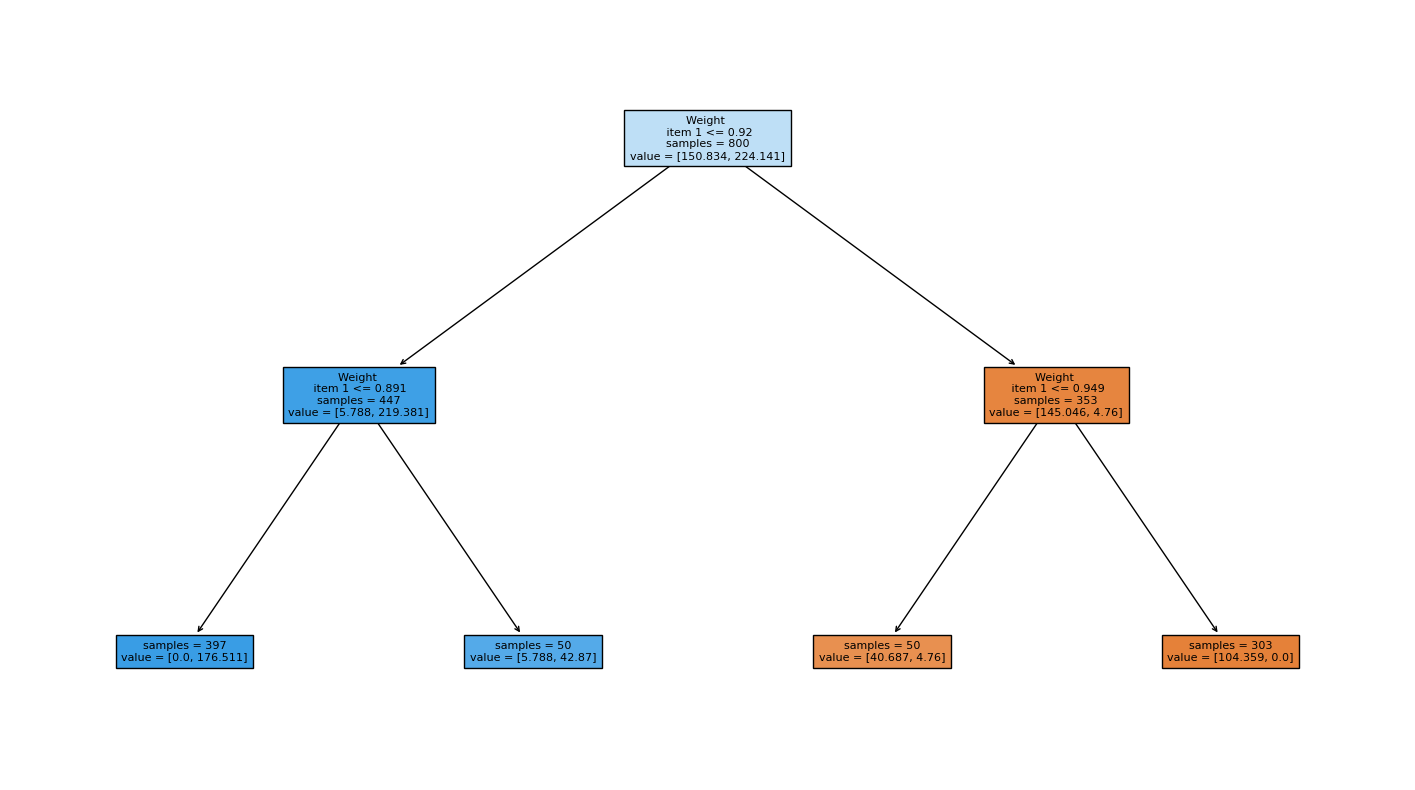

In [35]:
#Plot tree for DTR surrogate
plt.figure(figsize=(18,10))
plot_tree(outcome_dict_w_fsb['DecisionTreeClassifier']['Model'], feature_names = features_lbls_nl[10:20], fontsize=8, impurity=False, filled=True, max_depth=3)
plt.show()

# Larger experiment
Explaining the optimal value

## Constraint (=weight) parameters

### Model performance - hyperparameter tuning

In [36]:
# Set instance and features

all_instances = {}

for i in range(10):
    all_instances['Instance '+str(i+1)] = {}
    all_instances['Instance '+str(i+1)]['Values']   = np.random.normal(1, 0.3, size = 50)
    all_instances['Instance '+str(i+1)]['Weights']  = np.random.normal(0.04, 0.005, size = 50)
    all_instances['Instance '+str(i+1)]['Budget']   = [1.0]
    all_instances['Instance '+str(i+1)]['Features'] = [*range(50, 100)] 

    all_instances['Instance '+str(i+11)] = {}
    all_instances['Instance '+str(i+11)]['Values']  = np.random.uniform(0.1, 4, size = 50)
    all_instances['Instance '+str(i+11)]['Weights'] = np.random.uniform(0.01, 0.06, size = 50)
    all_instances['Instance '+str(i+11)]['Budget']  = [1.0]
    all_instances['Instance '+str(i+11)]['Features'] = [*range(50, 100)] 

for i in range(5):
    all_instances['Instance '+str(i+21)] = {}
    all_instances['Instance '+str(i+21)]['Values']  = np.random.normal(1, 0.3, size = 100)
    all_instances['Instance '+str(i+21)]['Weights'] = np.random.normal(0.04, 0.005, size = 100)
    all_instances['Instance '+str(i+21)]['Budget']  = [1.0]
    all_instances['Instance '+str(i+21)]['Features'] = [*range(100, 200)] 

    all_instances['Instance '+str(i+26)] = {}
    all_instances['Instance '+str(i+26)]['Values']  = np.random.uniform(0.1, 4, size = 100)
    all_instances['Instance '+str(i+26)]['Weights'] = np.random.uniform(0.01, 0.06, size = 100)
    all_instances['Instance '+str(i+26)]['Budget']  = [1.0]
    all_instances['Instance '+str(i+26)]['Features'] = [*range(100, 200)] 


pos_mdls_dict = {'DecisionTreeRegressor':  {'max_depth': [3, 4, 5],
                                            'min_samples_leaf': [50, 100, 150]},
                'LinearRegression':        {},
                'RidgeRegression':         {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
                'LASSORegression':         {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
                }

In [37]:
# Find best surrogate models for each instance
for key in all_instances.keys():
    all_instances[key]['Explainers'] = {}
    all_val = np.concatenate((all_instances[key]['Values'],all_instances[key]['Weights'],all_instances[key]['Budget']))
    
    samples = sample_perturbations_normal(all_val, all_instances[key]['Features'], model_lcl = model_KS_bin)
    yvalues = get_values_from_samples(samples, model_KS_bin)

    for wdth in weight_widths[2:]:
        weights_lcl = get_weights_from_samples(samples,  all_instances[key]['Features'], width=wdth)
        all_instances[key]['Explainers']['Weight width '+ str(wdth)] = train_test_explanation_models(pos_mdls_dict, samples, yvalues, weights_lcl, all_instances[key]['Features'], store_all=True)

Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many weights zero
Neighborhood too small, too many w

In [38]:
#Create dataframe with average error over 30 instances per surrogate model and hyperparameter set
df = pd.DataFrame.from_dict({(i,j,k,l): all_instances[i]['Explainers'][j][k][l]
                            for i in all_instances.keys() 
                            for j in all_instances[i]['Explainers'].keys()
                            for k in all_instances[i]['Explainers'][j].keys()
                            for l in all_instances[i]['Explainers'][j][k].keys()},
                            orient='index')
df.index.names = ['Instances', 'Weight width', 'Model type', 'Hyperparameters']
df = df.reset_index()
df['Weight width nr'] = df['Weight width'].str.split().str[-1].astype('float')
df = df[df['Weight width nr'].isin([0.0001, 0.001, 0.01, 0.1, 1, 10])]

df_ovrvw = df.groupby(['Model type', 'Hyperparameters', 'Weight width nr'])[['Wmse', 'mse', 'WL1e', 'L1e', 'R2']].mean()
df_ovrvw.to_clipboard()
display(df_ovrvw)

Wmse  \
Model type            Hyperparameters                           Weight width nr             
DecisionTreeRegressor {'max_depth': 3, 'min_samples_leaf': 100} 0.01             2.410635   
                                                                0.10             2.109880   
                                                                1.00             2.119969   
                                                                10.00            2.120097   
                      {'max_depth': 3, 'min_samples_leaf': 150} 0.01             2.072976   
...                                                                                   ...   
RidgeRegression       {'alpha': 1e-05}                          10.00            0.252016   
                      {'alpha': 1}                              0.01             3.072886   
                                                                0.10             2.087053   
                                                                1.00             2.065739   
                                                                10.00            2.065487   

                                                                                      mse  \
Model type            Hyperparameters                           Weight width nr             
DecisionTreeRegressor {'max_depth': 3, 'min_samples_leaf': 100} 0.01             3.459086   
                                                                0.10             2.122947   
                                                                1.00             2.120093   
                                                                10.00            2.120098   
                      {'max_depth': 3, 'min_samples_leaf': 150} 0.01             3.705261   
...                                                                                   ...   
RidgeRegression       {'alpha': 1e-05}                          10.00            0.252016   
                      {'alpha': 1}                              0.01             5.577980   
                                                                0.10             2.099730   
                                                                1.00             2.065861   
                                                                10.00            2.065488   

                                                                                     WL1e  \
Model type            Hyperparameters                           Weight width nr             
DecisionTreeRegressor {'max_depth': 3, 'min_samples_leaf': 100} 0.01             1.132784   
                                                                0.10             1.084716   
                                                                1.00             1.087223   
                                                                10.00            1.087258   
                      {'max_depth': 3, 'min_samples_leaf': 150} 0.01             1.029015   
...                                                                                   ...   
RidgeRegression       {'alpha': 1e-05}                          10.00            0.353743   
                      {'alpha': 1}                              0.01             1.294181   
                                                                0.10             1.081441   
                                                                1.00             1.076453   
                                                                10.00            1.076393   

                                                                                      L1e  \
Model type            Hyperparameters                           Weight width nr             
DecisionTreeRegressor {'max_depth': 3, 'min_samples_leaf': 100} 0.01             1.347393   
                                                                0.10             1.087973   
                                                                1.00             1.

### Proximity parameter

Text(0, 0.5, 'wmse')

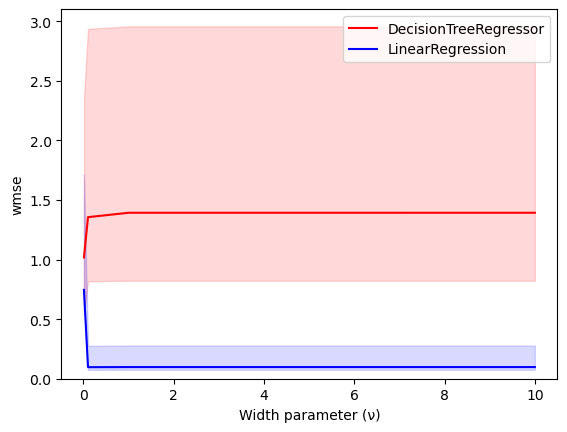

In [39]:
# Plot confidence intervals of specific models over different proximity parameters
plt_types  = ['DecisionTreeRegressor', 
    'LinearRegression'#,'RidgeRegression','LASSORegression'
    ]

df_sub = df[df['Hyperparameters'].isin([str({'max_depth': 5, 'min_samples_leaf': 150}), str({'alpha': 0.0001}), str({})])]
df_sub_ovrvw = df_sub.groupby(['Weight width nr', 'Model type', 'Hyperparameters']).agg({'Wmse': [('Q1', lambda x: np.quantile(x, 0.25)),
                                                                                               ('Q2', lambda x: np.quantile(x, 0.5)),
                                                                                               ('Q3', lambda x: np.quantile(x, 0.75))],
                                                                                        'mse': [('Q1', lambda x: np.quantile(x, 0.25)),
                                                                                               ('Q2', lambda x: np.quantile(x, 0.5)),
                                                                                               ('Q3', lambda x: np.quantile(x, 0.75))]})
df_sub_ovrvw = df_sub_ovrvw.reset_index()

fig, ax = plt.subplots()
colors = ['r', 'b', 'g', 'm']
cnt = 0

for mod_tp in plt_types:
    df_sub_ovrvw_mdl = df_sub_ovrvw[df_sub_ovrvw['Model type'] == mod_tp]
    x = df_sub_ovrvw_mdl['Weight width nr']
    ax.plot(x, df_sub_ovrvw_mdl[('Wmse', 'Q2')], color = colors[cnt], label = mod_tp)
    ax.fill_between(
        x, df_sub_ovrvw_mdl[('Wmse', 'Q1')], df_sub_ovrvw_mdl[('Wmse', 'Q3')], color=colors[cnt], alpha=.15)
    cnt = cnt +1
ax.set_ylim(ymin=0)
# ax.set_title('Quartiles Wmse')
plt.legend()
plt.xlabel("Width parameter (\u03BD)")
plt.ylabel("wmse")

### Stability outcome

In [40]:
# Resample 30 times Linear Regression model for instance 1 to investigate stability of explanation
fxd_instances = {k: all_instances[k] for k in ['Instance 1']}
width_fxd = 0.1
resample_size = 30
fxd_mdls_dict = {                'LinearRegression':        {}
                }

for key in fxd_instances.keys():
    fxd_instances[key]['Explainers'] = {}
    all_val = np.concatenate((fxd_instances[key]['Values'],fxd_instances[key]['Weights'],fxd_instances[key]['Budget']))
    for i in range(resample_size):
        print('Getting samples. Iteration '+str(i))
        samples = sample_perturbations_normal(all_val, fxd_instances[key]['Features'], model_lcl = model_KS_bin)
        fxd_instances[key]['Samples '+str(i+1)] = samples
        print('Getting Yvalues. Iteration '+str(i))
        yvalues = get_values_from_samples(samples, model_KS_bin)
        fxd_instances[key]['YValues '+str(i+1)] = yvalues
        print('Getting weights. Iteration '+str(i))
        weights_lcl = get_weights_from_samples(samples, fxd_instances[key]['Features'], width=wdth)
        fxd_instances[key]['Weights '+str(i+1)] = weights_lcl
        print('Fitting surrogate models. Iteration '+str(i))
        fxd_instances[key]['Explainers']['Samples '+ str(i+1)] = train_test_explanation_models(fxd_mdls_dict, samples, yvalues, weights_lcl, fxd_instances[key]['Features'], store_all=False)

Getting samples. Iteration 0
Getting Yvalues. Iteration 0
Getting weights. Iteration 0
Fitting surrogate models. Iteration 0
Getting samples. Iteration 1
Getting Yvalues. Iteration 1
Getting weights. Iteration 1
Fitting surrogate models. Iteration 1
Getting samples. Iteration 2
Getting Yvalues. Iteration 2
Getting weights. Iteration 2
Fitting surrogate models. Iteration 2
Getting samples. Iteration 3
Getting Yvalues. Iteration 3
Getting weights. Iteration 3
Fitting surrogate models. Iteration 3
Getting samples. Iteration 4
Getting Yvalues. Iteration 4
Getting weights. Iteration 4
Fitting surrogate models. Iteration 4
Getting samples. Iteration 5
Getting Yvalues. Iteration 5
Getting weights. Iteration 5
Fitting surrogate models. Iteration 5
Getting samples. Iteration 6
Getting Yvalues. Iteration 6
Getting weights. Iteration 6
Fitting surrogate models. Iteration 6
Getting samples. Iteration 7
Getting Yvalues. Iteration 7
Getting weights. Iteration 7
Fitting surrogate models. Iteration 7


In [41]:
# Create dataframe to plot stability boxplots later on
cols = ['Feature ' + str(i-49) for i in fxd_instances[key]['Features']]

df_st = pd.DataFrame.from_dict({(i,j,k): fxd_instances[i]['Explainers'][j][k]
                                for i in fxd_instances.keys() 
                                for j in fxd_instances[i]['Explainers'].keys()
                                for k in fxd_instances[i]['Explainers'][j].keys()},
                                orient='index')
df_st.index.names = ['Instance nr', 'Sample nr', 'Model type']
df_st = df_st.reset_index()
df_st = df_st[df_st['Model type'] != 'DecisionTreeRegressor']
df_st = df_st.reset_index(drop=True)
# split = pd.DataFrame(df_st['Best model coefficients'].to_list(),columns = cols)
split = pd.DataFrame(df_st['Best model model coefficients'].to_list(),columns = cols)
df_st = pd.concat([df_st, split], axis=1) 
display(df_st.tail())

KeyError: 'Best model model coefficients'

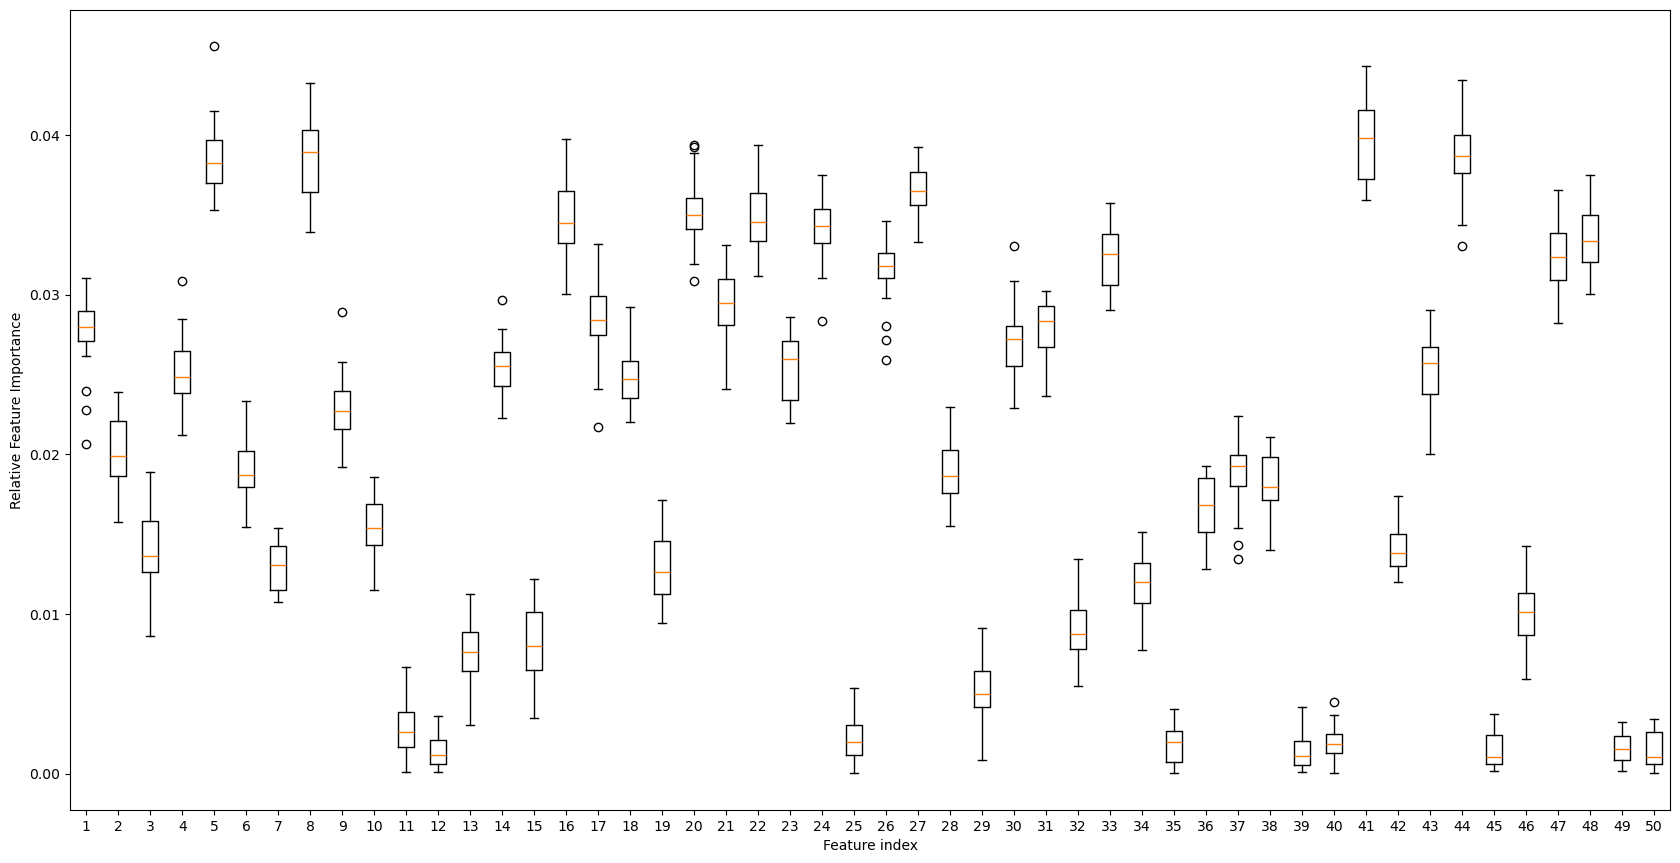

In [ ]:
# Plot boxplots of the linear regression features over 30 times resampling
df_st_mdl = df_st[df_st['Model type'] == 'LinearRegression']

fig = plt.figure(figsize=(16,8))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(df_st_mdl[cols])

# show plot
plt.xlabel('Feature index')
plt.ylabel('Model Coefficient')
plt.show()

In [ ]:
# determine % agreement over the 30 instances in the order of the first-k relative feature importance of Linear Regression surrogate
df_tst = df_st[['Instance nr', 'Sample nr', 'Model type', 'Best model feature importance']]
overlap = []
srted_indices = []

for i in range(len(df_tst[df_tst['Model type'] == 'LinearRegression'])):
    srtd_ind_ins = np.argsort(df_tst[df_tst['Model type'] == 'LinearRegression'].iloc[i]['Best model feature importance'])[::-1]
    srted_indices.append(srtd_ind_ins)

for i in range(1, len(srted_indices[0]) + 1):
    ovrlp = 0
    max_ovrlp = 0
    for j1 in range(len(srted_indices)):
        st1 = srted_indices[j1][:i]
        for j2 in range(j1+1, len(srted_indices)):
            st2 = srted_indices[j2][:i]
            lcl_intrsctn  = list(set(st1) & set(st2))
            ovrlp = ovrlp + len(lcl_intrsctn)
            max_ovrlp = max_ovrlp + i
    overlap.append(ovrlp/max_ovrlp)

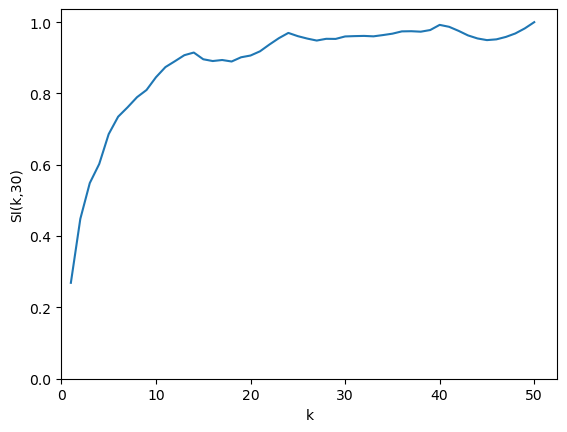

In [ ]:
# plot % agreement over the 30 instances in the order of the first-k relative feature importance of Linear Regression surrogate
x = [*range(1,len(srted_indices[0]) + 1)]  # X-axis points

plt.plot(x, overlap)  # Plot the chart
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlabel('k')
plt.ylabel('SI(k,30)')
plt.show()